In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import utils
import preprocessing

In [10]:
params = { 'n_estimators': [1001], 'criterion': ['gini'], 'max_depth': [25], 'max_features': ['log2']}
model = RandomForestClassifier()

### Preprocessing base

In [4]:
df_base = preprocessing.preprocessing_base_parte_1(utils.feature_engineering(utils.get_data()))

In [11]:
gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=10)

In [12]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_base.drop('tiene_alto_valor_adquisitivo',1), df_base['tiene_alto_valor_adquisitivo'], random_state=112)

In [13]:
%%time
gscv_base.fit(X_train_base, y_train_base)
score_base = roc_auc_score(y_test_base, gscv_base.predict_proba(X_test_base)[:,1])

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

CPU times: user 18.4 s, sys: 1.12 s, total: 19.5 s
Wall time: 1h 25min 57s


In [14]:
gscv_base.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 150}

In [15]:
score_base

0.9055286808893214

In [16]:
print(classification_report(y_test_base,gscv_base.predict(X_test_base)))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      6182
           1       0.53      0.88      0.66      1959

    accuracy                           0.79      8141
   macro avg       0.74      0.82      0.75      8141
weighted avg       0.85      0.79      0.80      8141



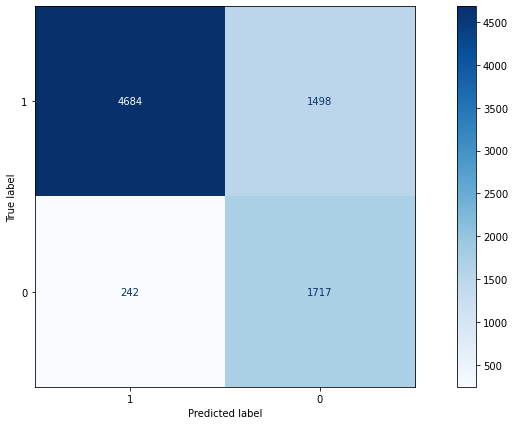

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_base, X_test_base, y_test_base, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

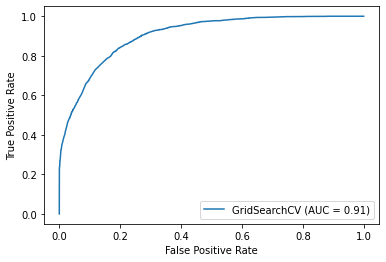

In [18]:
plot_roc_curve(gscv_base, X_test_base, y_test_base)

### Preprocessing Significantes

In [6]:
df_sig, pa_sig = preprocessing.preprocessing_significantes(utils.feature_engineering(utils.get_data()))

In [11]:
gscv_sig = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=4, cv=2)

In [12]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(df_sig, pa_sig, random_state=112)

In [13]:
%%time
gscv_sig.fit(X_train_sig, y_train_sig)
score_sig = roc_auc_score(y_test_sig, gscv_sig.predict_proba(X_test_sig)[:,1])

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  3.9min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  5.1min remaining:   53.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


CPU times: user 1min 44s, sys: 454 ms, total: 1min 44s
Wall time: 6min 51s


In [14]:
gscv_sig.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'log2',
 'n_estimators': 1001}

In [15]:
score_sig

0.8833495258427001

In [16]:
print(classification_report(y_test_sig,gscv_sig.predict(X_test_sig)))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      6182
           1       0.68      0.59      0.63      1959

    accuracy                           0.83      8141
   macro avg       0.78      0.75      0.76      8141
weighted avg       0.83      0.83      0.83      8141



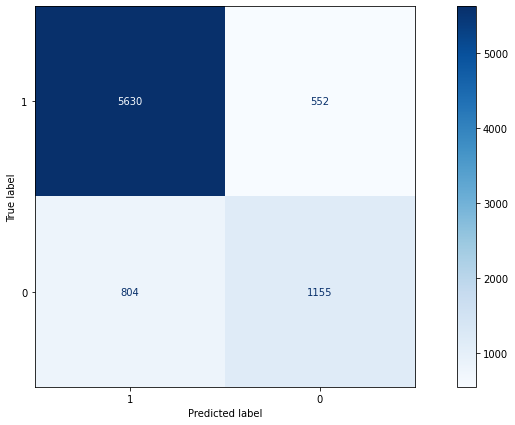

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_sig, X_test_sig, y_test_sig, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

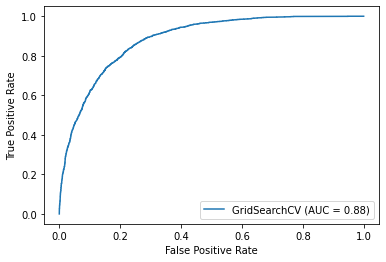

In [18]:
plot_roc_curve(gscv_sig, X_test_sig, y_test_sig)